In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import sys
sys.path.append('../../')
from helpers import graphs
%matplotlib inline
words = open('../../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [2]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)* (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [5]:
bngain.shape

torch.Size([1, 200])

In [ ]:
import numpy as np
def print_emb(emb, i):
    emb_np = emb.detach().numpy()

    # Set numpy print options for better formatting (optional)
    np.set_printoptions(precision=4, suppress=True)

    # Print the emb tensor
    print(f"Batch {i} embeddings:")
    print(emb_np)

In [12]:
# same optimization as last time
#hidden layer neurons 200
#bngain [1,1,----1] size 200
#0 -> 200 , 
#1 ->200
#32 -> 200
max_steps = 200000
batch_size = 32
lossi = []

for i in range(1):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  normalized_values = (hpreact - bnmeani) / bnstdi
  hpreact_n = bngain * normalized_values + bnbias
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact_n) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # if i % 10000 == 0: # print every once in a while
  #   print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  # lossi.append(loss.log10().item())

In [19]:
bngain

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], requires_grad=True)

In [ ]:
Xb.size(), emb.size(), embcat.size(), hpreact.size(), bnmeani.size()

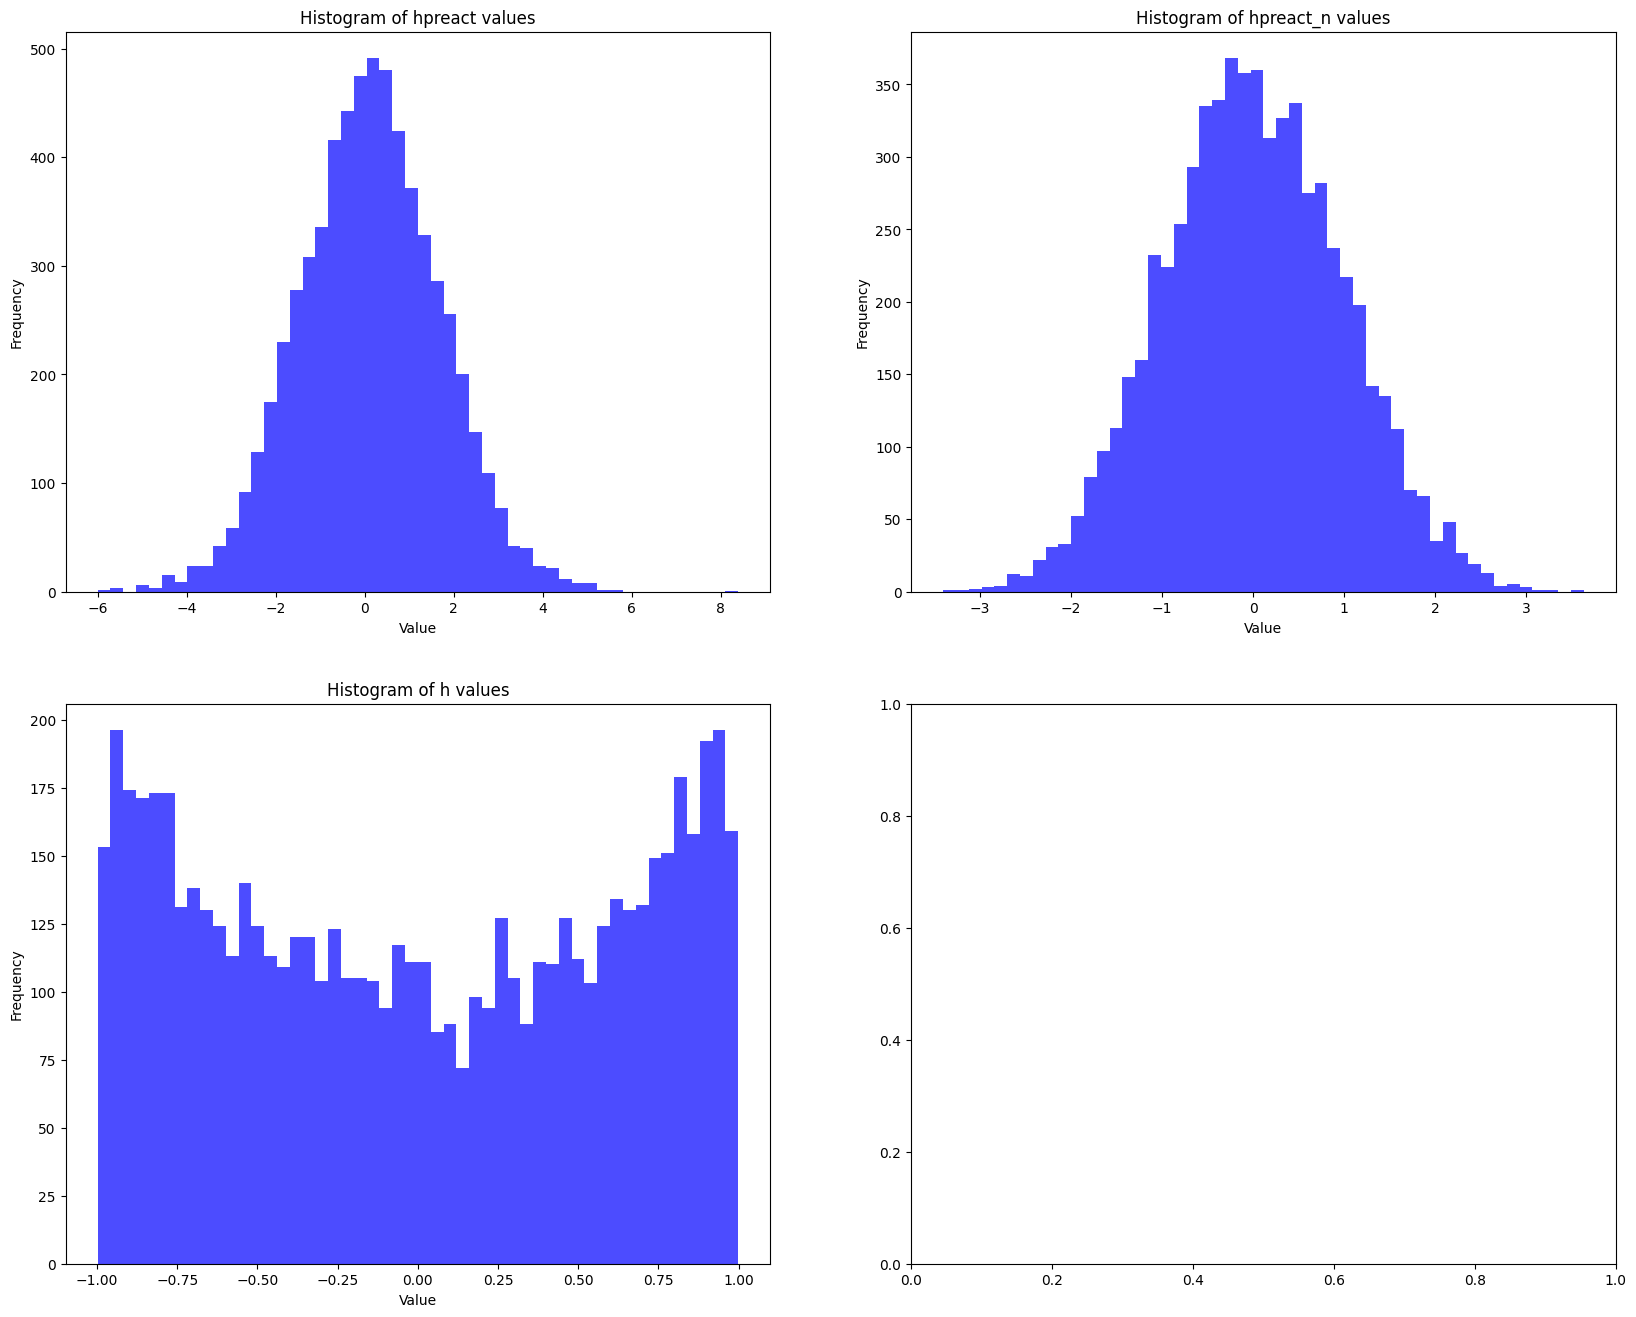

In [21]:
graphs.four_graphs(hpreact, hpreact_n, h )

In [ ]:
graphs.four_graphs(hpreact, hpreact_n, h )

In [ ]:
from math import log


arr = np.arange(1, 10000)
log_series = np.log(arr)
log_series

In [ ]:
plt.plot(arr, log_series, marker='o')
plt.title('Logarithmic Graph of the Series')
plt.xlabel('Data Series')
plt.ylabel('Log of Series')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# 1) Create a data series which has right-skewed data
np.random.seed(0)
# Generating a right-skewed dataset using the chi-square distribution
data = np.random.chisquare(2, 1000)
data_series = pd.Series(data)

# 2) Calculate mean and median of the above data series
original_mean = data_series.mean()
original_median = data_series.median()

# 3) Now transform data series into log of data series
log_data_series = np.log(data_series)

# 4) Calculate mean and median of log data series
log_mean = log_data_series.mean()
log_median = log_data_series.median()

(original_mean, original_median, log_mean, log_median)


In [ ]:
np.log([5,10,15,20,25])

In [ ]:
np.mean([1.60943791, 2.30258509, 2.7080502 , 2.99573227, 3.21887582]), np.mean([5,10,15,20,25])

In [ ]:
np.median([1.60943791, 2.30258509, 2.7080502 , 2.99573227, 3.21887582]), np.median([5,10,15,20,25])

In [ ]:
#32 [...]
#[...] -> [.2,.3,-2........................10] - 30

#N1-N200 = [.2,.1,-1, ---------------------- 3]
[.2,.1,-1, ---------------------- 20]
[.2,.1,-1, ---------------------- 3]
[.2,.1,-1, ---------------------- 3]

#hpreact = [20,.3,-2,.2..........]
arr = 5,10,15,20,25,30,35,45,1000

std = np.std(arr)
mean = np.mean(arr)

nor = []
for item in arr:
    nor.append( ((item-mean)/std))

nor,mean,std

In [ ]:
np.tanh(nor)

In [ ]:
std_all = 0
result = []
for item in arr:
    std_all += (mean-item)**2
    result.append(((mean-item)**2)**.5)

std_all = std_all/len(arr)

std_all, std_all**.5, result

#arr = 5,10,15,20,25,30,35,45

In [ ]:
import torch
a = torch.tensor(1.0)
b = torch.tensor(2.0)
w1 = torch.tensor(.25)
ypred = a*w1
loss = (b-ypred)**2

In [ ]:
w1 = torch.tensor(2.5)


torch.randn(27,100)

In [3]:
import numpy as np
arr = [ 1,2,3,4,5,1000]

np.std(arr), np.mean(arr)

(371.56220505081274, 169.16666666666666)

In [42]:
import torch

x1 = torch.tensor(.1, requires_grad=True)
w1 = torch.tensor(.2, requires_grad=True)

a = x1*w1 # 0.0036
b = torch.tensor(1.0, requires_grad=True) #-0.0792

c = a * b # grad = -3.1274
#c = a
d = torch.tanh(c) #- grad = -3.4174
loss = (2 - d)**2
a.retain_grad()
c.retain_grad()
d.retain_grad()
loss.retain_grad()


loss.backward()


print(a.grad,b.grad, c.grad, d.grad, loss.grad)

tensor(-3.9584) tensor(-0.0792) tensor(-3.9584) tensor(-3.9600) tensor(1.)


In [41]:
a,b,c,c.grad

(tensor(0.3000, grad_fn=<AddBackward0>),
 tensor(1., requires_grad=True),
 tensor(0.3000, grad_fn=<MulBackward0>),
 tensor(-3.1274))